# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from minisom import MiniSom

from sklearn.metrics import silhouette_score

from tqdm import tqdm

In [2]:
np.random.seed(42)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

# Loading data & preprocessing

In [3]:
path_to_data = './../../data/ftir_data/ftir_scaled.csv'
path_to_description = './../../data/ftir_data/ftir_description.csv'

In [4]:
# reading data
data_scaled = pd.read_csv(path_to_data)

# setting indexes
data_scaled.index = data_scaled.iloc[:, 0].tolist()
data_scaled.index.values[1:] = data_scaled.index.values[1:].astype(int)

# deleting useless column
if 'Unnamed: 0' in data_scaled.columns:
    data_scaled = data_scaled.drop(columns=['Unnamed: 0'])

data_scaled.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
wavenumber,1900.766600,1899.802230,1898.837870,1897.873500,1896.909130,1895.944770,1894.980400,1894.016030,1893.051670,1892.087300,1891.122930,1890.158570,1889.194200,1888.229830,1887.265470,1886.301100,1885.336730,1884.372370,1883.408000,1882.44364,1881.479270,1880.514900,1879.550540,1878.586170,1877.621800,...,823.569090,822.604720,821.640360,820.675990,819.711620,818.747260,817.782890,816.818520,815.854160,814.889790,813.925420,812.961060,811.996690,811.032320,810.067960,809.103590,808.139230,807.174860,806.210490,805.246130,804.281760,803.317390,802.353030,801.388660,800.424290
1,0.000494,0.000944,0.001362,0.001750,0.002112,0.002451,0.002770,0.003074,0.003364,0.003646,0.003921,0.004193,0.004467,0.004744,0.005028,0.005324,0.005633,0.005960,0.006308,0.00668,0.007079,0.007509,0.007974,0.008476,0.009019,...,0.037121,0.035323,0.033560,0.031835,0.030152,0.028514,0.026926,0.025390,0.023910,0.022491,0.021135,0.019846,0.018627,0.017483,0.016417,0.015433,0.014533,0.013723,0.013004,0.012382,0.011859,0.011440,0.011127,0.010924,0.010836
2,0.000210,0.000215,0.000213,0.000205,0.000192,0.000175,0.000155,0.000132,0.000109,0.000085,0.000063,0.000042,0.000025,0.000011,0.000003,0.000000,0.000004,0.000017,0.000039,0.00007,0.000113,0.000168,0.000236,0.000318,0.000415,...,0.072690,0.071565,0.070364,0.069083,0.067721,0.066275,0.064743,0.063123,0.061413,0.059610,0.057713,0.055719,0.053626,0.051432,0.049135,0.046732,0.044221,0.041600,0.038868,0.036021,0.033058,0.029976,0.026773,0.023447,0.019997


In [5]:
# reading data
samples_description = pd.read_csv(path_to_description)

# setting indexes
samples_description.index = samples_description.iloc[:, 0].tolist()
samples_description.index.values[1:] = samples_description.index.values[1:].astype(int)

# deleting useless column
if 'Unnamed: 0' in samples_description.columns:
    samples_description = samples_description.drop(columns=['Unnamed: 0'])

samples_description.head(3)

,Description,Type,Class
1,"MFGO, разб. 1:20",$GO$,1
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1


In [6]:
wavenumber = data_scaled.iloc[0]
data = data_scaled.iloc[1:, :]

# selecting only go data
go_indexes = samples_description.loc[samples_description['Type'] == '$GO$'].index
go_data = data.loc[go_indexes]

# selecting only go dialysis data
god_indexes = samples_description.loc[samples_description['Type'] == '$GO_{d}$'].index
god_data = data.loc[god_indexes]

# selecting only rgo data
rgo_indexes = samples_description.loc[samples_description['Type'] == '$rGO$'].index
rgo_data = data.loc[rgo_indexes]

# Clustering using *MiniSom*

In [7]:
path_to_save = './../../results/ftir/clustering_minisom'

## Class for clustering

In [36]:
class SomStructureAnalysis():
    def __init__(self, data):
        if type(data) is pd.core.frame.DataFrame:
            self.train_data = data.to_numpy()
        elif type(data) is list:
            self.train_data = np.array(data)
        else:
            self.train_data = data
        
    def fit_transform_som(self, shape=(1, 2), sigma=0.5, learning_rate=0.5, num_iteration=10_000, random_seed=42, verbose=True):
        train_data = self.train_data
        estimator = MiniSom(x=shape[0],
                            y=shape[1],
                            input_len=train_data.shape[1],
                            sigma=sigma,
                            learning_rate=learning_rate,
                            neighborhood_function='gaussian',
                            random_seed=random_seed)
        
        estimator.train_batch(data=train_data, num_iteration=num_iteration, verbose=verbose)

        winner_coordinates = np.array([estimator.winner(x) for x in train_data]).T
        predictions = np.ravel_multi_index(winner_coordinates, shape)

        data_with_predictions = pd.DataFrame(train_data)
        data_with_predictions['Prediction'] = predictions

        cluster_centers = data_with_predictions.groupby(['Prediction']).agg('mean').reset_index().iloc[:, 1:].to_numpy()

        self.n_clusters = int(shape[0] * shape[1])
        self.estimator = estimator
        self.predictions = predictions
        self.train_data_predictions = data_with_predictions
        self.cluster_centers = cluster_centers
    
    def get_silhouette_score(self):
        train_data = self.train_data
        predictions = self.predictions
        if self.n_clusters >= 2:
            silhouette = silhouette_score(train_data, predictions)
        else:
            silhouette = None
        return silhouette

    def get_metric_in_range(self, metric='silhouette', num_iteration=2_000, max_n_clusters=None):
        train_data = self.train_data
        if max_n_clusters is None:
            max_n_clusters = train_data.shape[0] - 1
        shapes_arr = range(1, max_n_clusters+1)

        metric_values = []
        shape_values = []
        
        for shape1 in tqdm(shapes_arr):
            for shape2 in shapes_arr:
                if (shape1 * shape2 >= 2) and (shape1 * shape2 <= max_n_clusters):
                    n_clusters = shape1 * shape2
                else:
                    continue
                self.fit_transform_som(shape=(shape1, shape2), num_iteration=num_iteration, verbose=False)
                if metric == 'silhouette':
                    value = self.get_silhouette_score()
                metric_values.append(value)
                shape_values.append(f'({shape1}; {shape2})')
        return metric_values, shape_values

    def get_metrics_visualization(self, metric='silhouette', num_iteration=1_000, max_n_clusters=None, figsize=(11, 7.5), rotation_x=0, path_to_save=None, dpi=300):
        if max_n_clusters is None:
            max_n_clusters = self.train_data.shape[0] - 1
    
        if metric == 'silhouette':
            metric_values, shape_of_grid_arr = self.get_metric_in_range(metric='silhouette', num_iteration=num_iteration, max_n_clusters=max_n_clusters)
        elif metric == 'inertia':
            metric_values, shape_of_grid_arr = self.get_metric_in_range(metric='inertia', num_iteration=num_iteration, max_n_clusters=max_n_clusters)

        qm_df_vis = pd.DataFrame(
            {
            'Shape of grid': shape_of_grid_arr,
            'Value': metric_values
            }
        )

        # qm_df_vis = qm_df_vis.sort_values(by='Value', ascending=False)
        
        sns.set_theme()

        fig = plt.figure(figsize=figsize, dpi=600, linewidth=1.0)
        
        ax = fig.gca()
        
        ax.grid(True)
        ax.tick_params(direction='in')
        
        bar = sns.barplot(data=qm_df_vis,
                          x='Shape of grid',
                          y='Value',
                          palette='mako',
                          ax=ax)

        ax.set_ylabel('Metric value',
                      fontstyle='normal',
                      fontsize=14,
                      rotation=90,
                      labelpad=5)
        
        ax.set_xlabel('Shape of grid',
                      fontstyle='normal',
                      fontsize=14,
                      rotation=0,
                      labelpad=5)
        
        bar.set_xticklabels(bar.get_xticklabels(), rotation=rotation_x, fontsize=12)
        
        plt.tight_layout()

        if path_to_save is not None:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

    def get_spectra_clusters_visualization(self, shape, wavenumber, nrows, ncols, num_iteration=10_000, figsize=(10, 6), color='dodgerblue', path_to_save=None, dpi=300):
        self.fit_transform_som(shape=shape, num_iteration=num_iteration)
        data_with_labels = self.train_data_predictions
        centroids = self.cluster_centers

        n_clusters = int(shape[0] * shape[1])

        fig = plt.figure(figsize=figsize, dpi=600)
        
        for i in range(len(centroids)):
            temp_data = data_with_labels.loc[data_with_labels['Prediction'] == i].iloc[:, :-1].to_numpy()
            temp_centroid = centroids[i]
        
            ax = plt.subplot(nrows, ncols, i+1)
            
            for spectrum in temp_data:
                ax.plot(wavenumber, spectrum, linewidth=1.5, color=color)
        
            ax.plot(wavenumber, temp_centroid, linestyle='--', linewidth=2.0, color='black', label='Centroid')
        
            ax.set_xlabel('Wavenumber, cm$^{-1}$', fontstyle='normal', fontsize=12, labelpad=5)
            ax.set_ylabel('A', fontstyle='italic', fontsize=12, labelpad=15, rotation=0)
        
            ax.invert_xaxis()
        
            ax.legend()

        plt.tight_layout()
        
        if path_to_save is not None:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

## Clustering

In [9]:
path_to_save = './../../results/ftir/clustering_minisom'

### *GO*

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 2.431250817259689


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  4.53it/s]


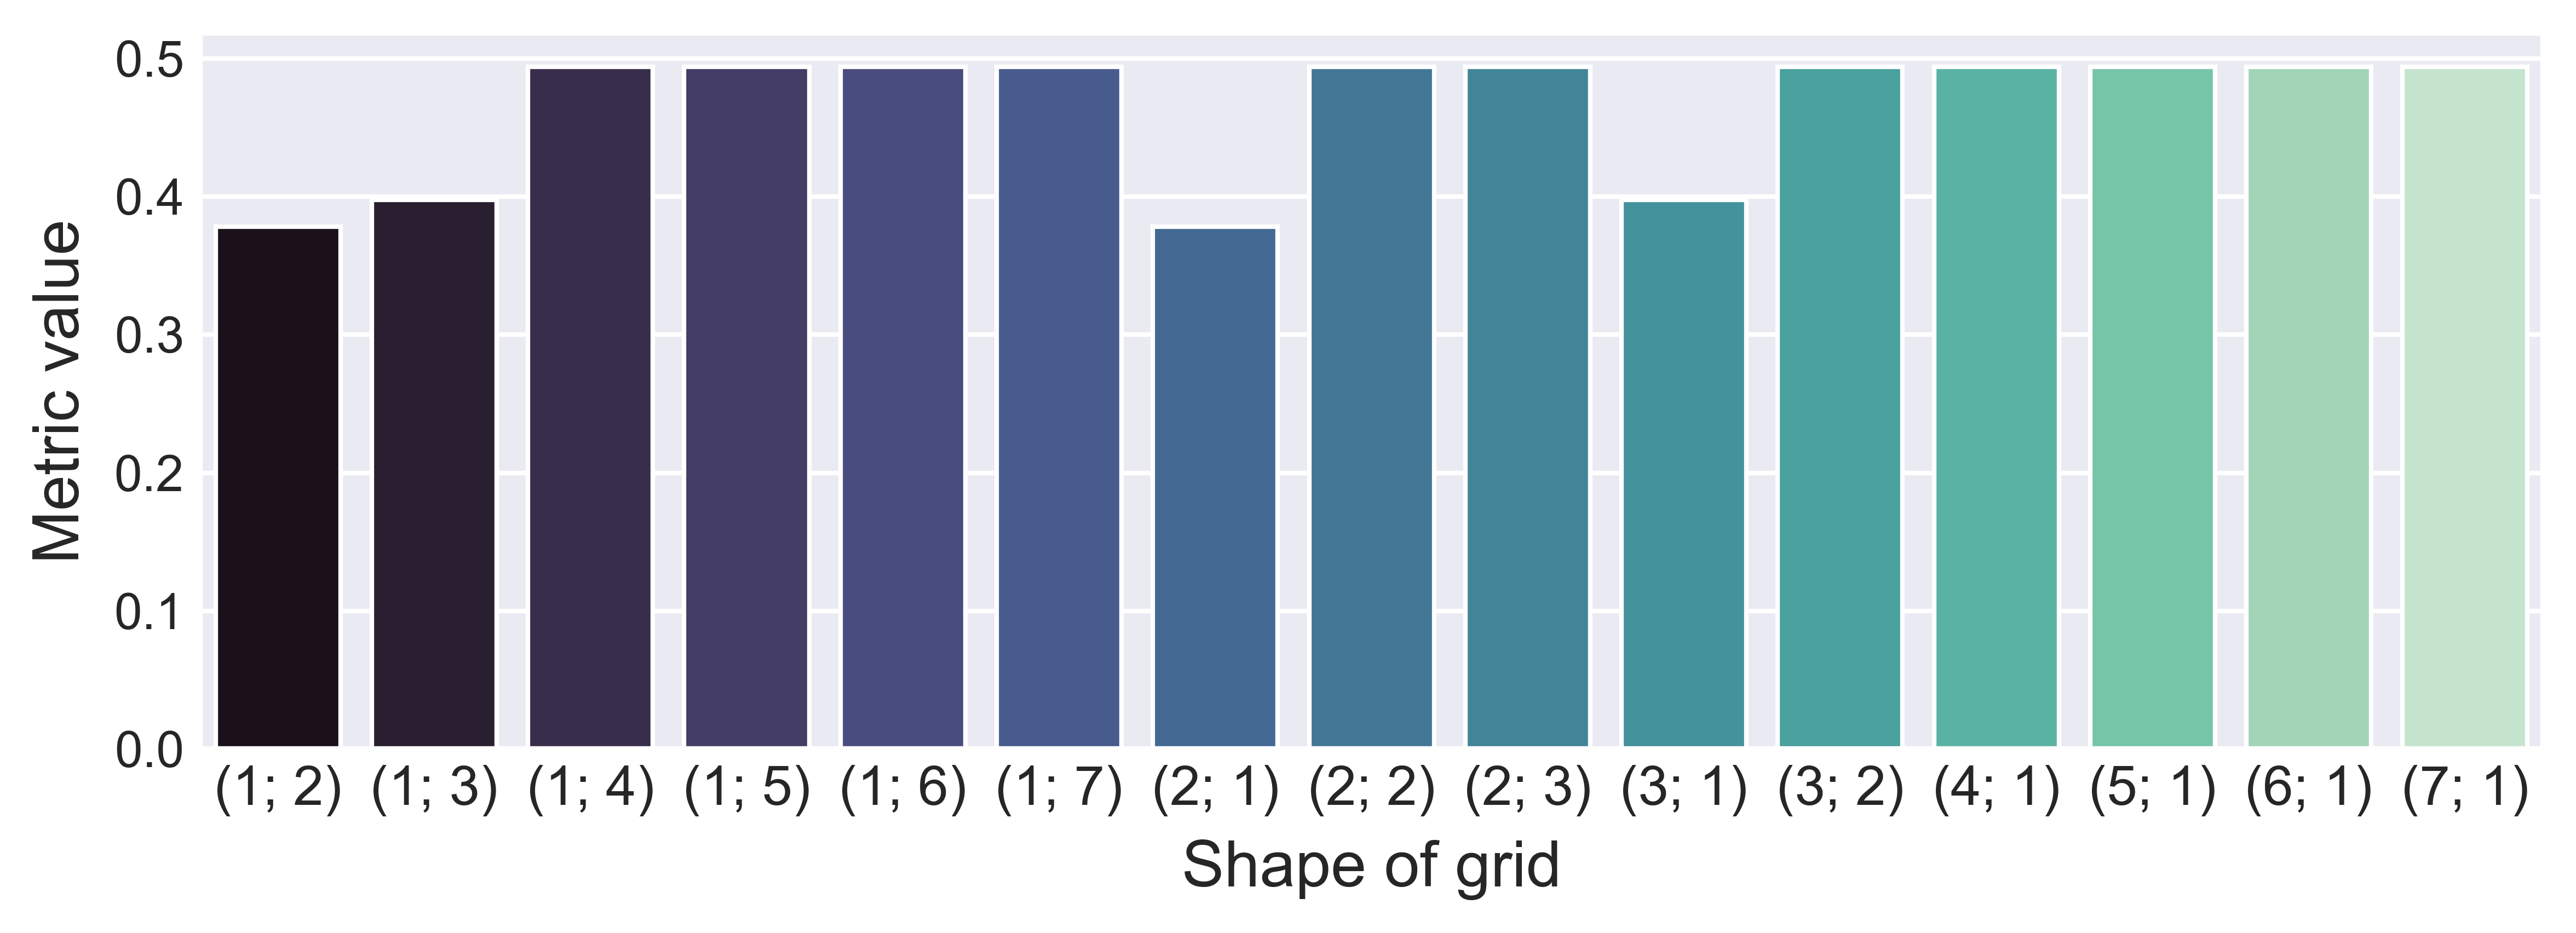

In [10]:
test_an = SomStructureAnalysis(go_data)
test_an.fit_transform_som(shape=(1, 2), sigma=0.5, learning_rate=0.5, num_iteration=1_000, random_seed=42)

test_an.get_metrics_visualization(metric='silhouette', num_iteration=1_000, figsize=(8, 3), rotation_x=0,
                                  path_to_save=path_to_save + '/go_metrics.png', dpi=600)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.8206322570355252


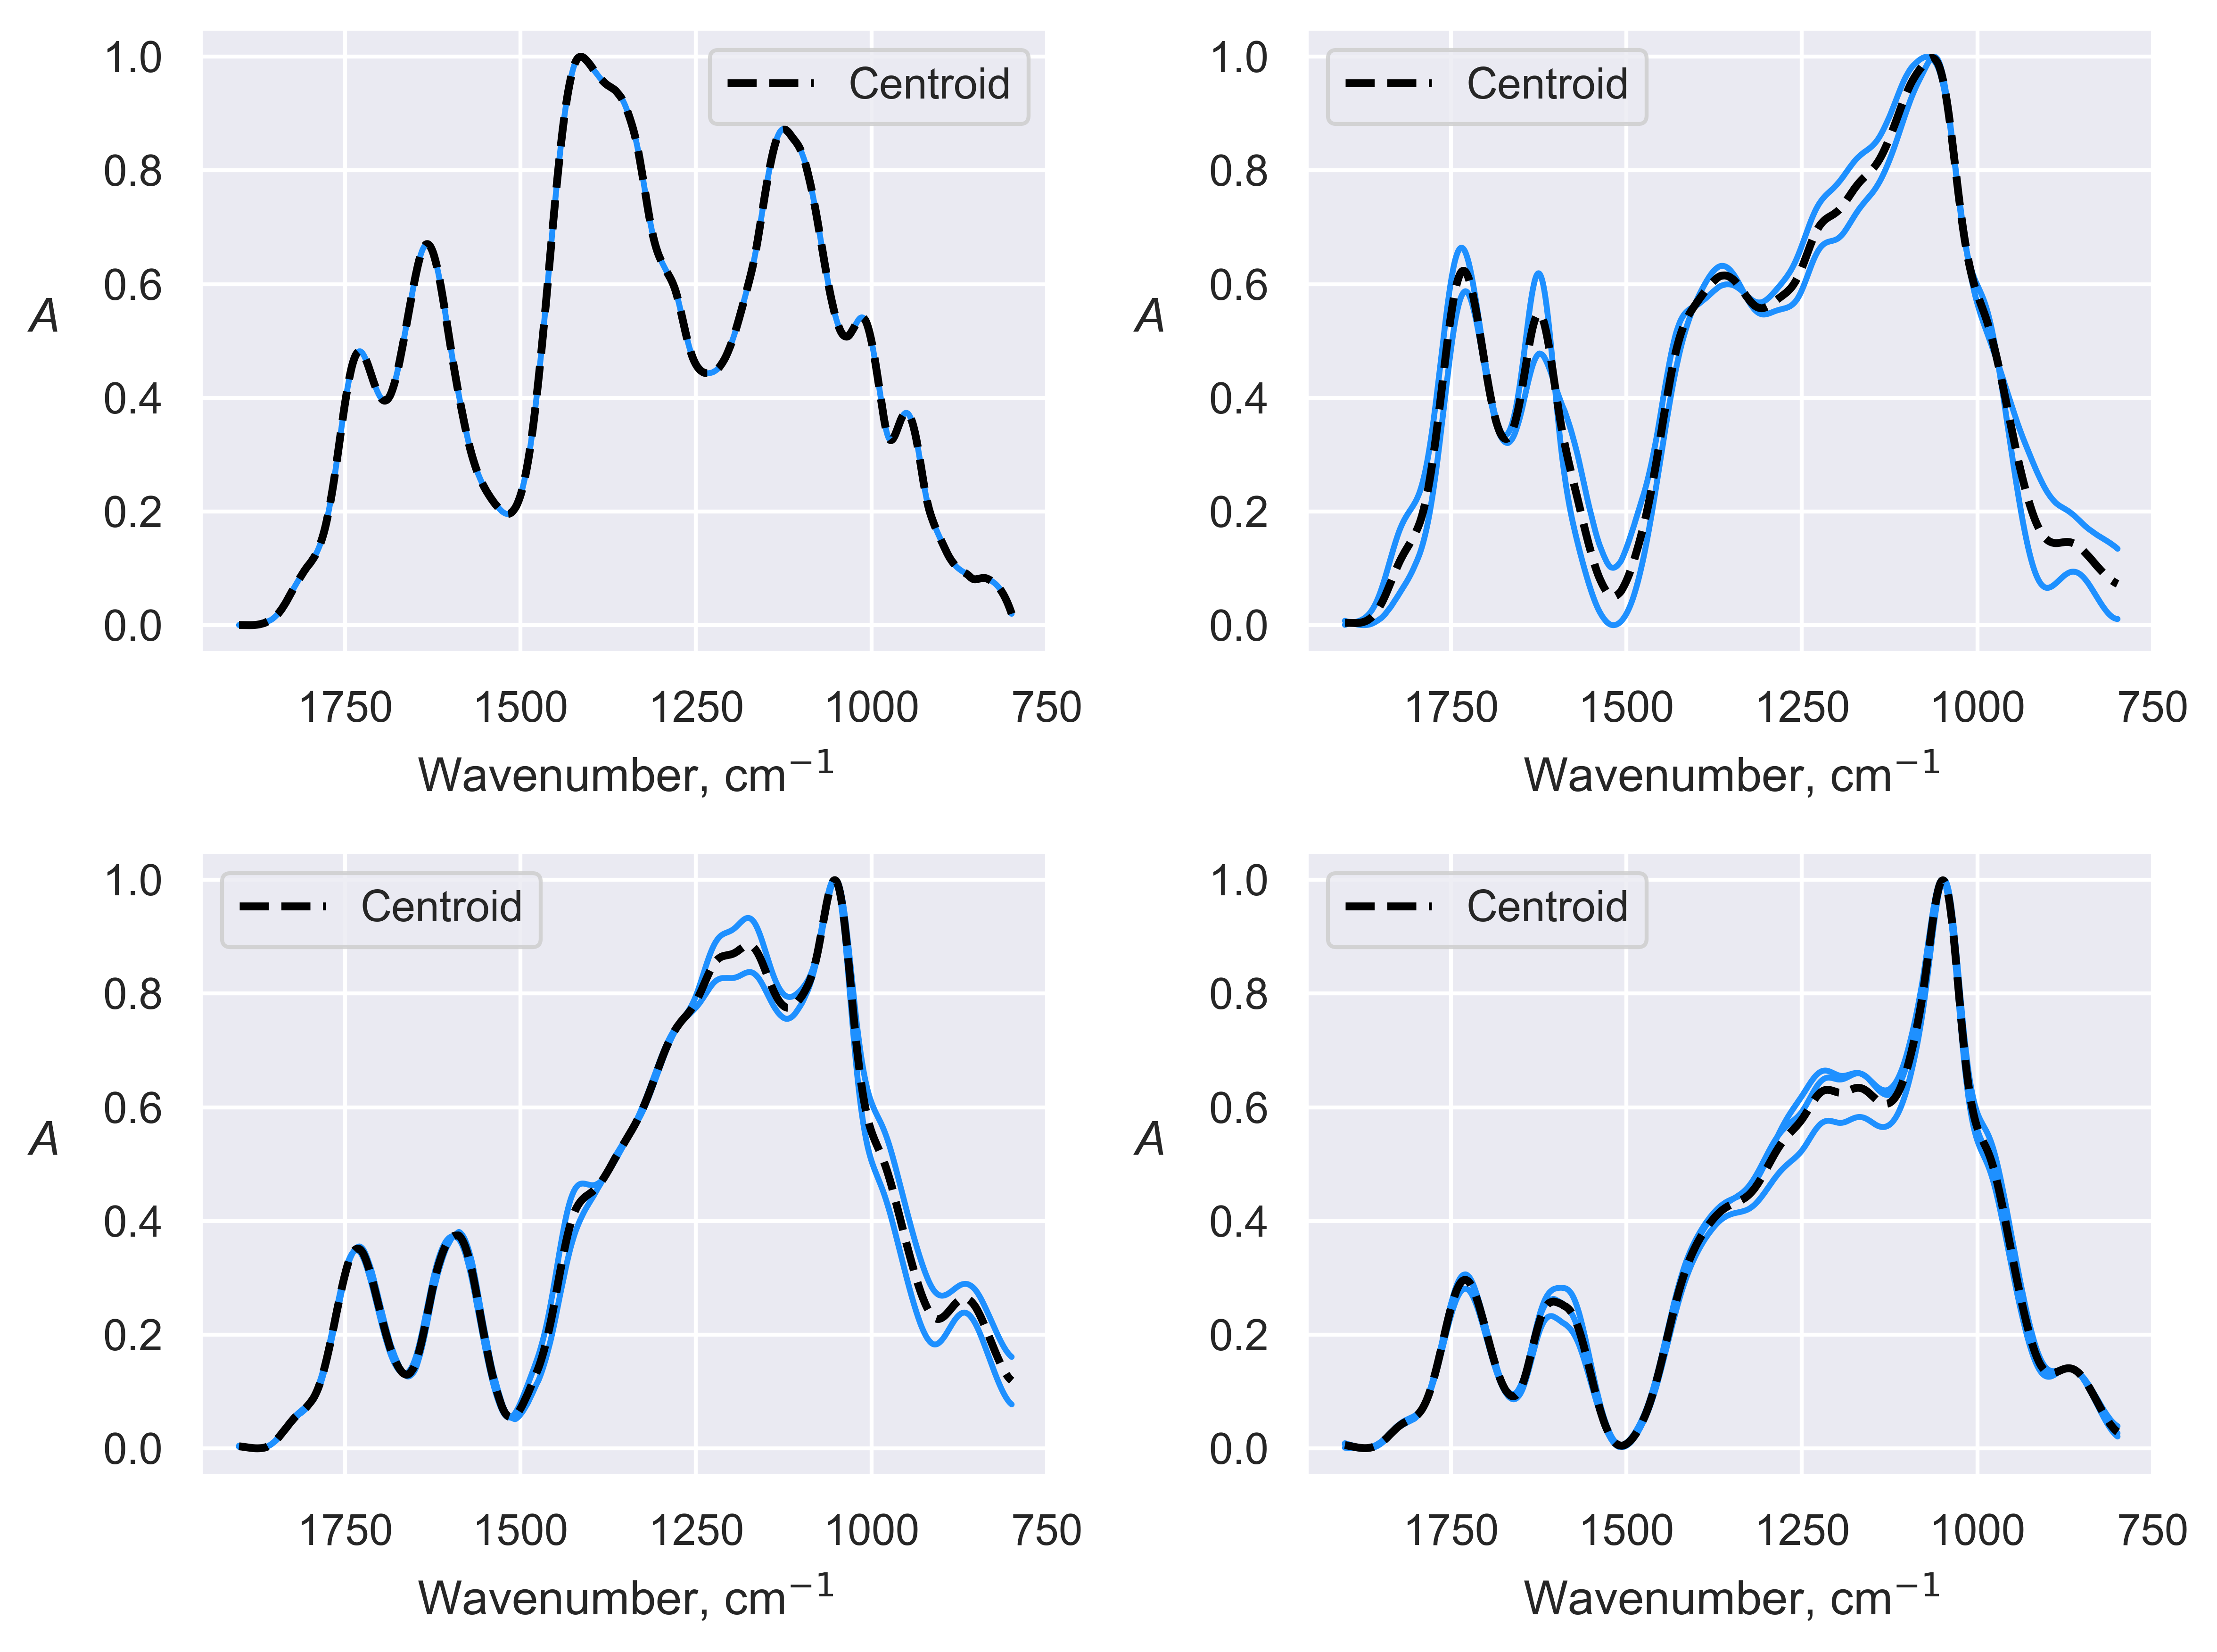

In [11]:
test_an.get_spectra_clusters_visualization(shape=(1, 4), wavenumber=wavenumber,
                                           ncols=2, nrows=2, figsize=(8, 6), color='dodgerblue',
                                           path_to_save=path_to_save + '/go_clusters.png', dpi=600)

### *rGO*

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.6889931623575863


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.74it/s]


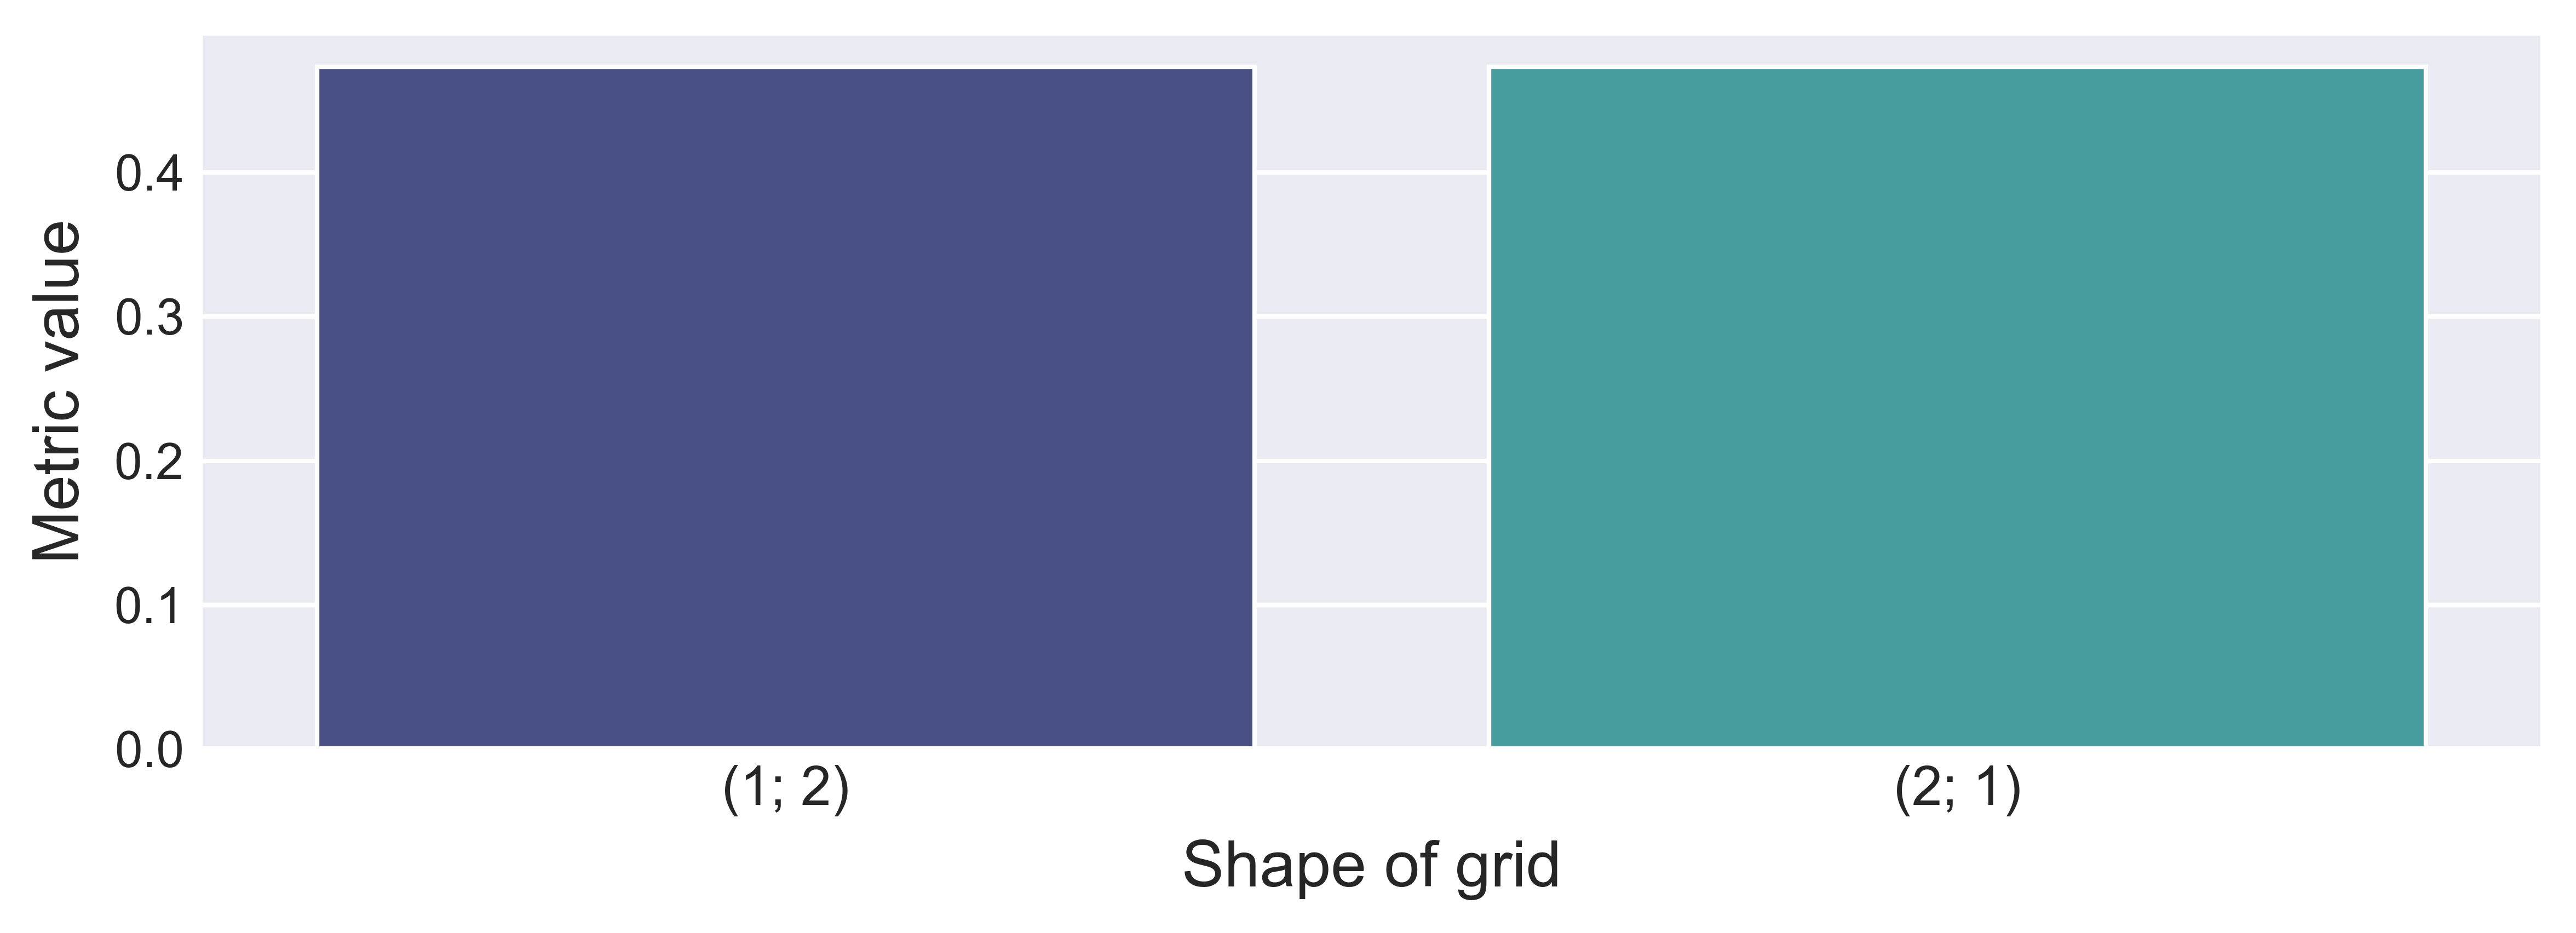

In [12]:
test_an = SomStructureAnalysis(rgo_data)
test_an.fit_transform_som(shape=(1, 2), sigma=0.5, learning_rate=0.5, num_iteration=1_000, random_seed=42)

test_an.get_metrics_visualization(metric='silhouette', num_iteration=1_000, figsize=(8, 3),
                                  path_to_save=path_to_save + '/rgo_metrics.png', dpi=600)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.6889931207621522


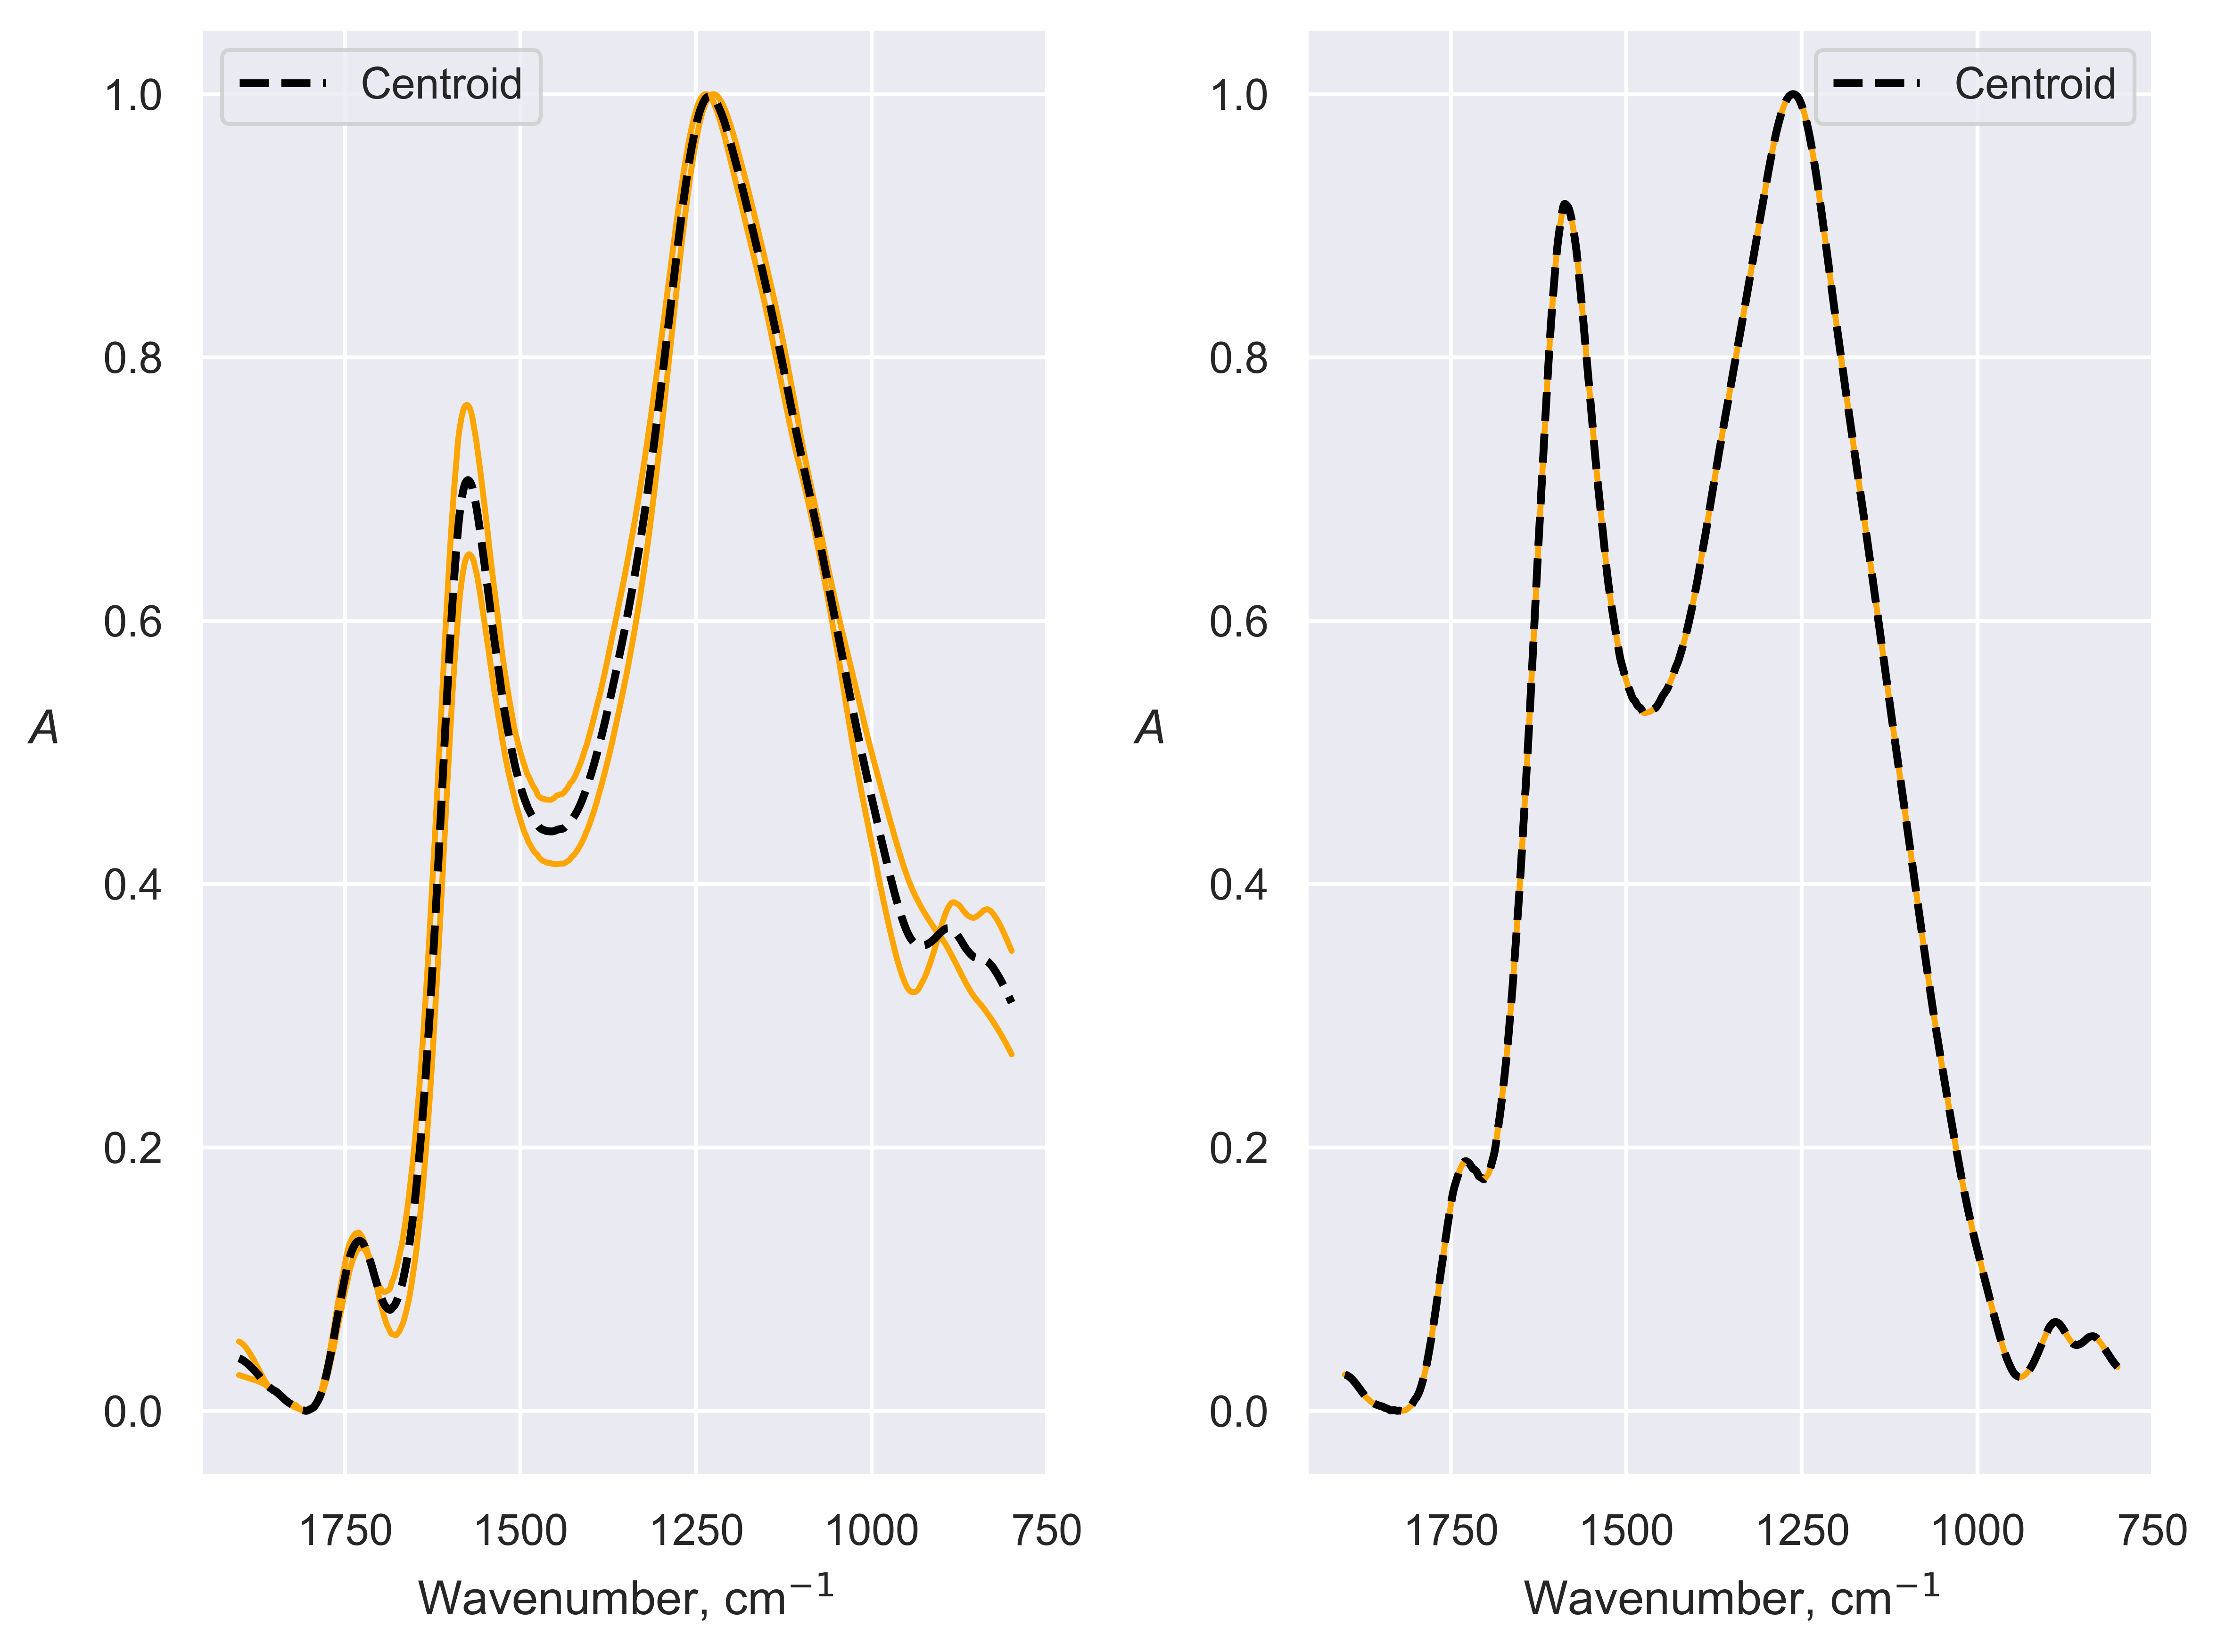

In [13]:
test_an.get_spectra_clusters_visualization(shape=(1, 2), wavenumber=wavenumber,
                                           ncols=2, nrows=1, figsize=(8, 6), color='orange',
                                           path_to_save=path_to_save + '/rgo_clusters.png', dpi=600)

### $GO_{d}$

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 2.431274428416974


100%|███████████████████████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


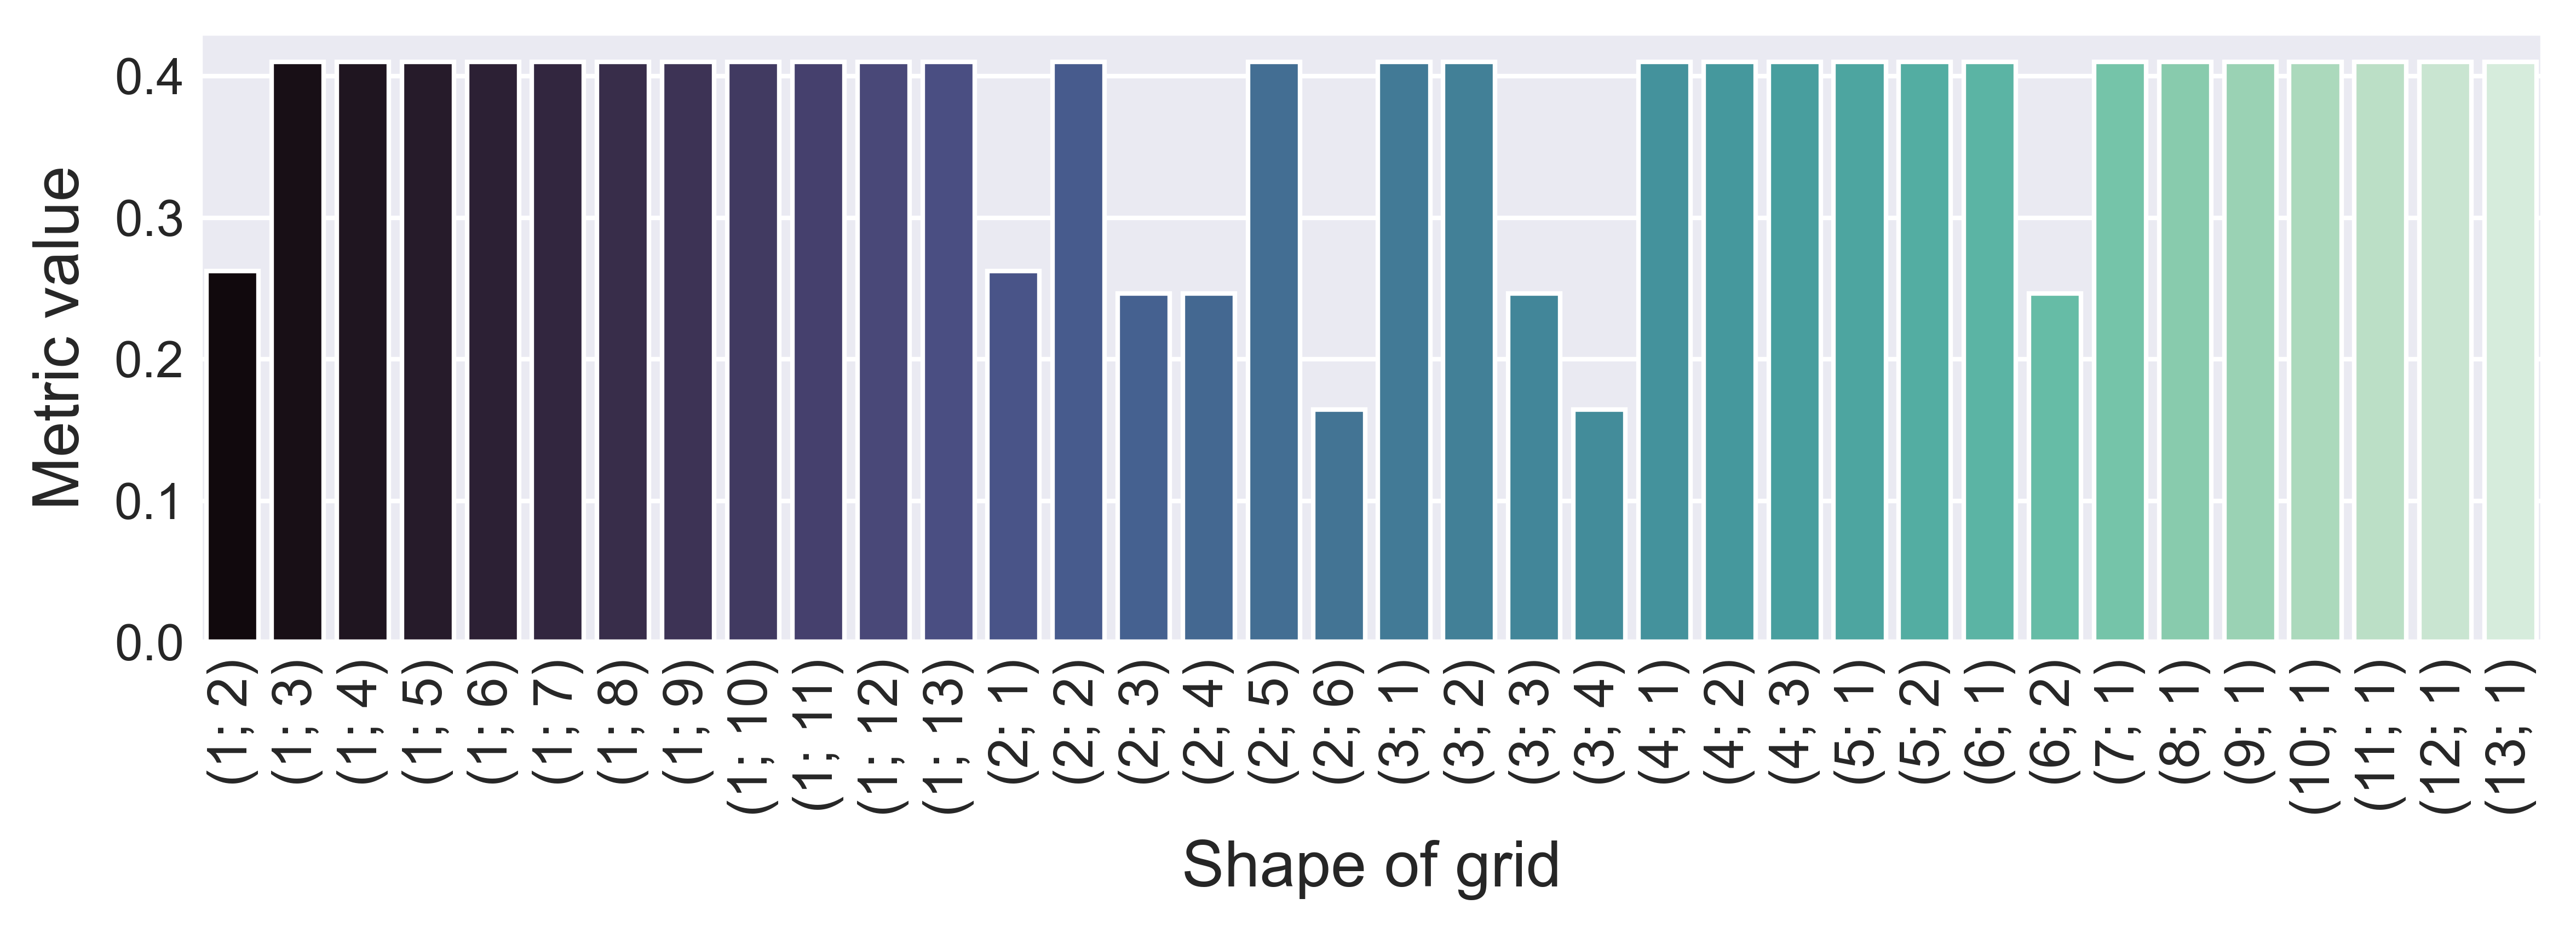

In [37]:
test_an = SomStructureAnalysis(god_data)
test_an.fit_transform_som(shape=(1, 2), sigma=0.5, learning_rate=0.5, num_iteration=1_000, random_seed=42)

test_an.get_metrics_visualization(metric='silhouette', num_iteration=1_000, figsize=(8, 3), rotation_x=90,
                                  path_to_save=path_to_save + '/god_metrics.png', dpi=600)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 1.475563527349251


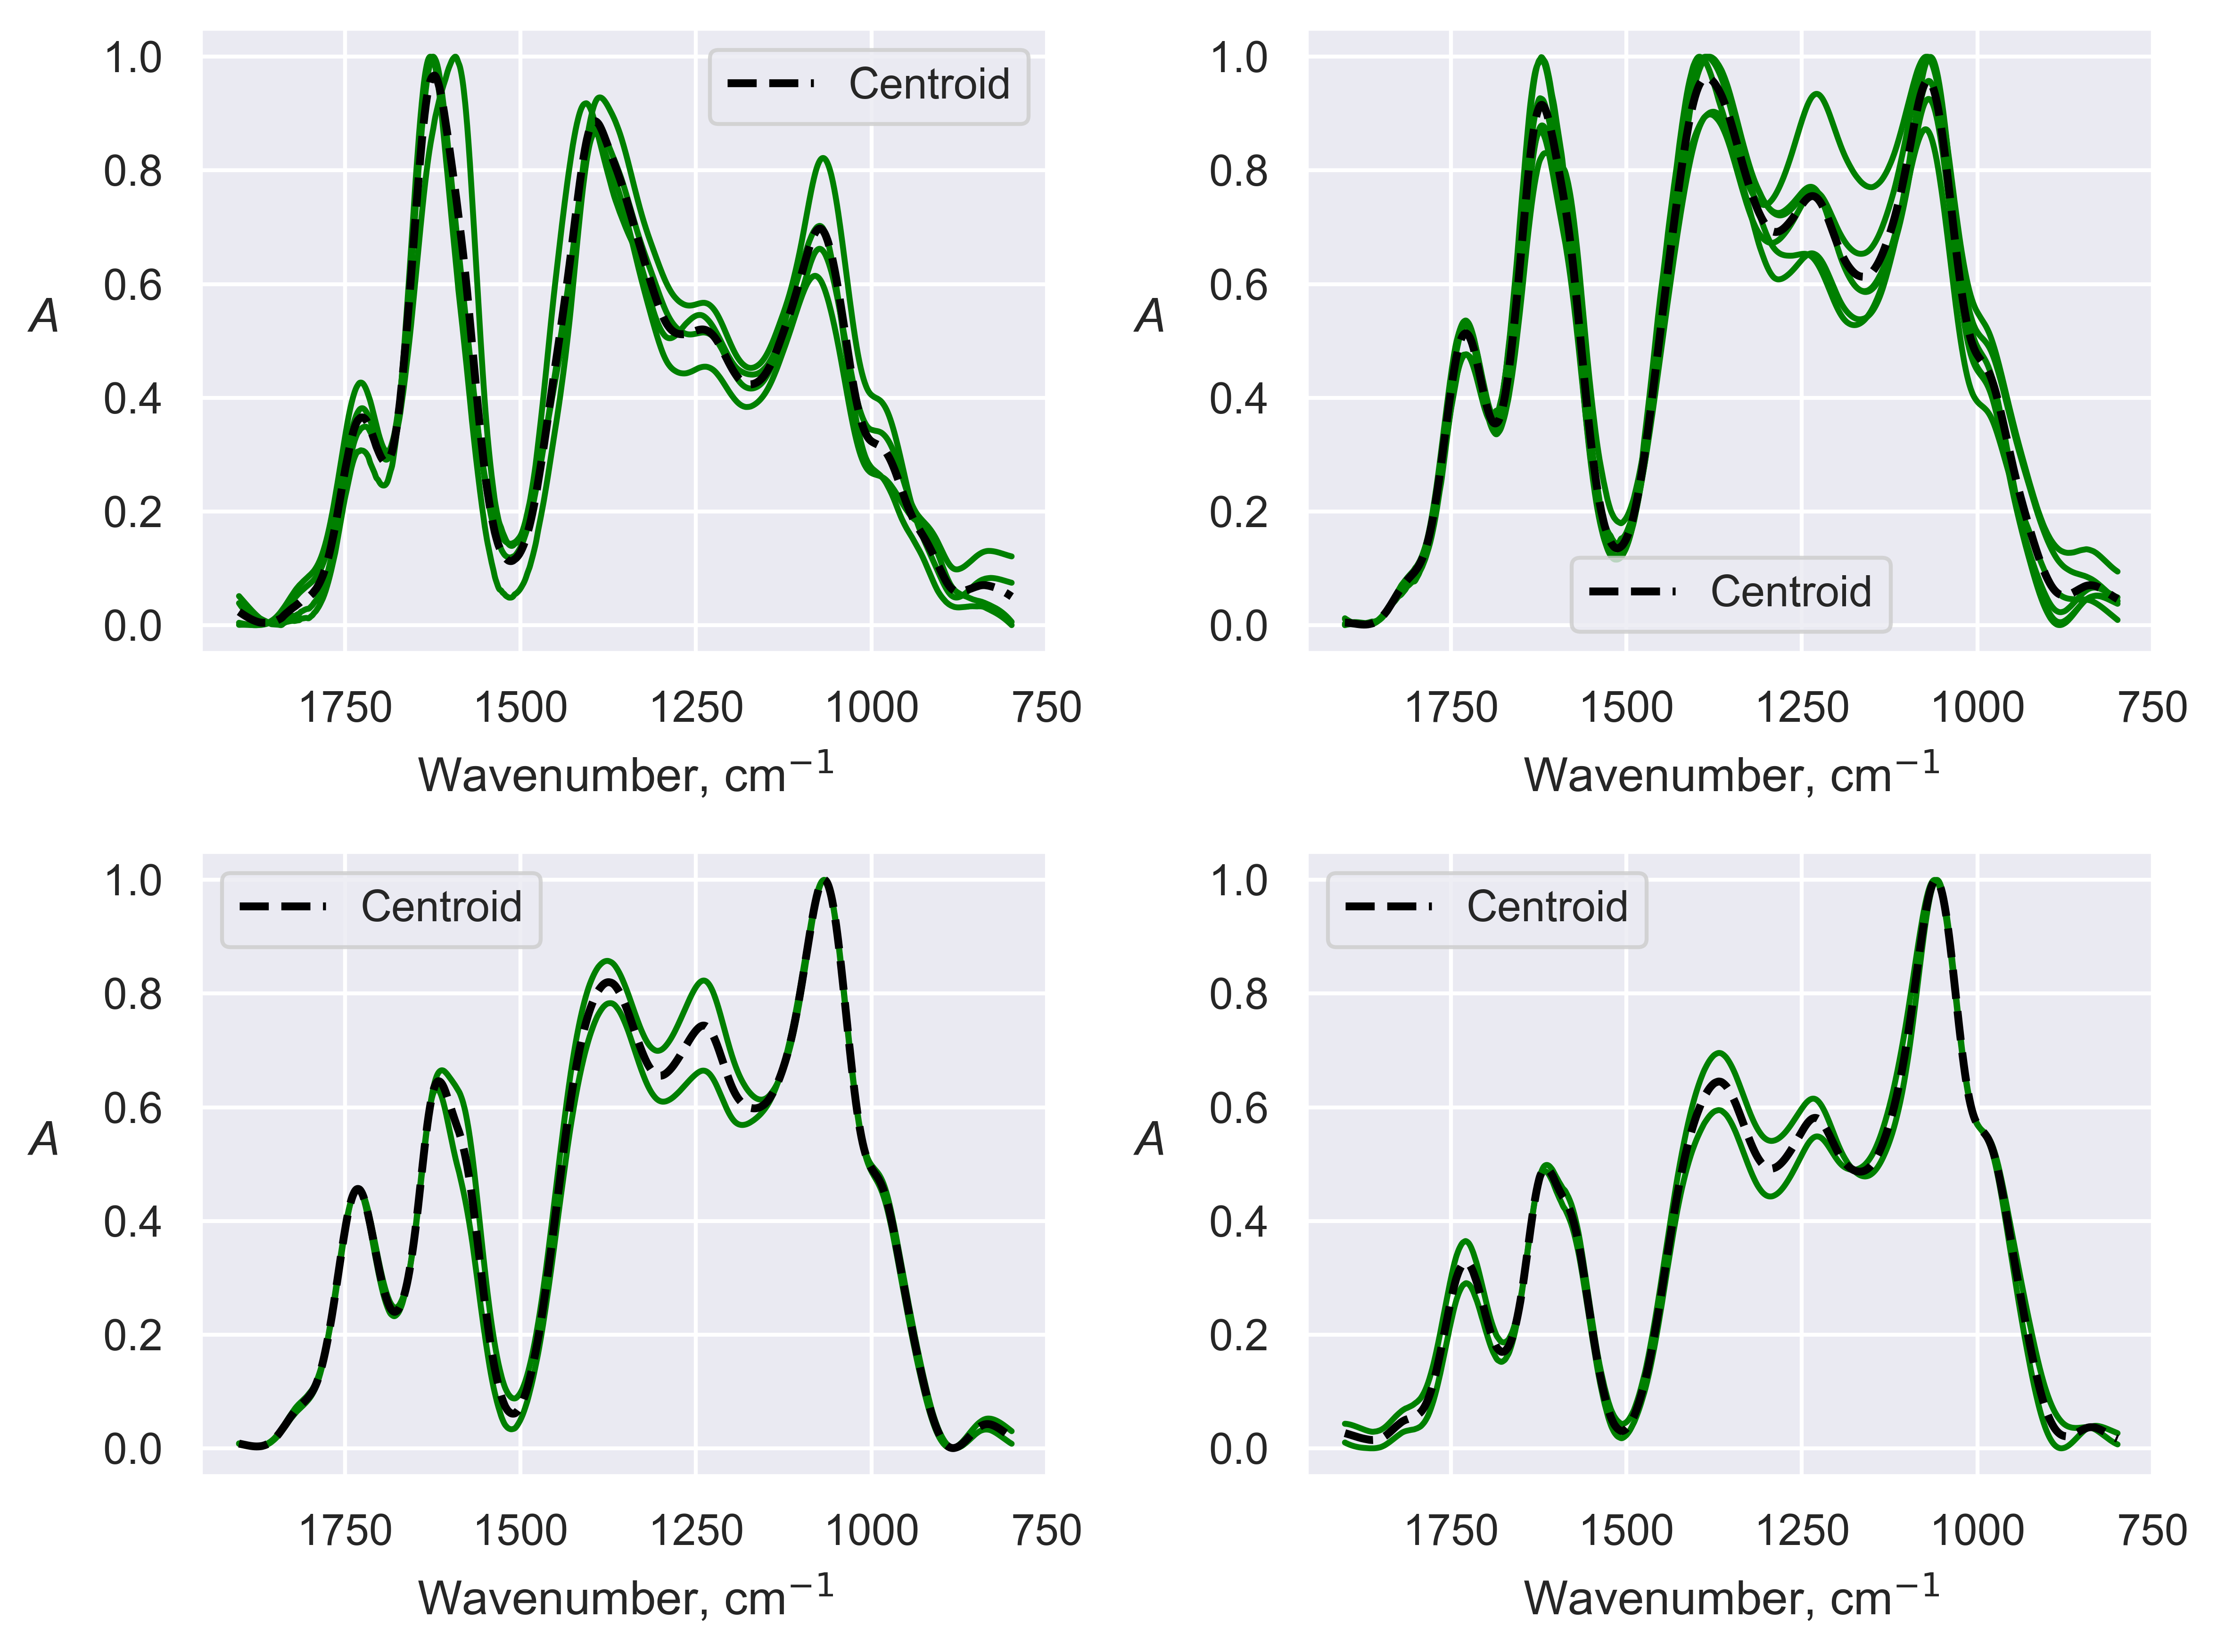

In [42]:
test_an.get_spectra_clusters_visualization(shape=(4, 1), wavenumber=wavenumber, num_iteration=5_000,
                                           ncols=2, nrows=2, figsize=(8, 6), color='green',
                                           path_to_save=path_to_save + '/god_clusters.png', dpi=600)